In [1]:
idmap_train_dir = 'ai4bio_trainset/trainmap.csv'
methy_train_dir = 'ai4bio_trainset/traindata.csv'
idmap_test_dir = 'ai4bio_testset_final/testmap.csv'
methy_test_dir = 'ai4bio_testset_final/testdata.csv'
output_root = "output/"

In [2]:
import pandas as pd
import h5py


def savefile(methy_dir, chunk_size, name):
    df_chunks = pd.read_csv(methy_dir,
                            sep=',',
                            index_col=0,
                            chunksize=chunk_size)

    with h5py.File(name, 'w') as file:
        total_cols = 0
        for i, chunk in enumerate(df_chunks):
            chunk = chunk.transpose()
            chunk = chunk.fillna(0)
            # fill nan with 0, you can try other methods
            data_array = chunk.to_numpy()
            chunk_cols = data_array.shape[1]
            if i == 0:
                samples_num = data_array.shape[0]
                dataset = file.create_dataset('data',
                                              shape=data_array.shape,
                                              maxshape=(samples_num, None))

            dataset.resize((dataset.shape[0], total_cols + chunk_cols))

            dataset[:, total_cols:total_cols + chunk_cols] = data_array

            total_cols += chunk_cols  # Update total_cols within the loop

    return None


chunk_size = 5000

savefile(methy_train_dir, chunk_size, 'train.h5')
print('transform traindata over')

savefile(methy_test_dir, chunk_size, 'test.h5')
print('transform testdata over')

transform traindata over


FileNotFoundError: [Errno 2] No such file or directory: 'ai4bio_testset_final/testdata.csv'

In [2]:
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR  # Import the SVR model
import time
import matplotlib.pyplot as plt
import random

sample_type_mapping = {'control': 0, 'disease tissue': 1}

def load_idmap(idmap_dir):
    idmap = pd.read_csv(idmap_dir, sep=',')
    age = idmap.age.to_numpy()
    age = age.astype(np.float32)
    sample_type = idmap.sample_type.replace(sample_type_mapping)
    return age, sample_type


def load_methylation(methy_dir):
    methylation = pd.read_csv(methy_dir, sep=',', index_col=0, nrows=5000, usecols=range(5000))
    methylation.fillna(0, inplace=True)
    methylation = methylation.values.T.astype(np.float32)
    return methylation

def load_methylation_h5(prefix):
    methylation = h5py.File(prefix, 'r')['data']
    h5py.File(prefix, 'r').close()
    return methylation[:, :20000]  # 5000 just for test
#     return methylation[:, :]  # If you want to use full data, you can use this line.

def train_svr(X_train, y_train):
    svr = SVR(kernel='linear', C=1.0)
    svr.fit(X_train, y_train)
    return svr

def evaluate_ml(y_true, y_pred, sample_type):
    mae_control = np.mean(
        np.abs(y_true[sample_type == 0] - y_pred[sample_type == 0]))

    case_true = y_true[sample_type == 1]
    case_pred = y_pred[sample_type == 1]
    above = np.where(case_pred >= case_true)
    below = np.where(case_pred < case_true)

    ae_above = np.sum(np.abs(case_true[above] - case_pred[above])) / 2
    ae_below = np.sum(np.abs(case_true[below] - case_pred[below]))
    mae_case = (ae_above + ae_below) / len(case_true)

    mae = np.mean([mae_control, mae_case])
    return mae, mae_control, mae_case

# Load idmap
age, sample_type = load_idmap(idmap_train_dir)
print("ID map loaded.")

age_train = age[:5000]
age_test = age[5000:]

print("age_train shape:", age_train.shape)
print("age_test shape:",age_test.shape)

sample_train = sample_type[:5000]
sample_test = sample_type[5000:]

print("sample_train shape:", sample_train.shape)
print("sample_test shape:",sample_test.shape)

# Load methylation data
methylation_data = load_methylation_h5('train.h5')
print("\nMethylation data loaded.")

train_data = methylation_data[:5000]
test_data = methylation_data[5000:]

print("methylation_train shape:", train_data.shape)
print("methylation_test shape:", test_data.shape)

# Split data into training and validation sets

random.seed(10)

indices = np.arange(sample_train.shape[0])
[indices_train, indices_valid, age_train, age_valid] = train_test_split(indices, age_train, test_size=0.3, shuffle=True)

methylation_train = train_data[indices_train]
methylation_valid = train_data[indices_valid]

sample_type_train = sample_train[indices_train]
sample_type_valid = sample_train[indices_valid]

feature_size = methylation_train.shape[1]
del methylation_data

print('Start training...')
start = time.time()

pred_model = train_svr(methylation_train, age_train)
print(f'Training time: {time.time() - start}s')

age_valid_pred = pred_model.predict(methylation_valid)
valid_mae = evaluate_ml(age_valid, age_valid_pred, sample_type_valid)
print(f'Validation MAE: {valid_mae}')
age_valid_pred[age_valid_pred < 0] = 0

age_test_pred = pred_model.predict(test_data)
test_mae = evaluate_ml(age_test, age_test_pred, sample_test)
print(f'Test MAE: {test_mae}')
age_test_pred[age_test_pred < 0] = 0

ID map loaded.
age_train shape: (5000,)
age_test shape: (3233,)
sample_train shape: (5000,)
sample_test shape: (3233,)

Methylation data loaded.
methylation_train shape: (5000, 20000)
methylation_test shape: (3233, 20000)
Start training...
Training time: 109.71516799926758s
Validation MAE: (3.166093906243084, 4.112661261515888, 2.21952655097028)
Test MAE: (5.20201965389292, 5.23224624722865, 5.17179306055719)


In [3]:
from sklearn.metrics import r2_score

age_valid_pred = pred_model.predict(methylation_valid)
age_test_pred = pred_model.predict(test_data)

# Calculate R^2 values
r2_valid = r2_score(age_valid, age_valid_pred)
r2_test = r2_score(age_test, age_test_pred)

age_valid_pred[age_valid_pred < 0] = 0
age_test_pred[age_test_pred < 0] = 0

print(f'Validation R^2: {r2_valid}')
print(f'Test R^2: {r2_test}')

Validation R^2: 0.9497348480251083
Test R^2: 0.8132642107052822


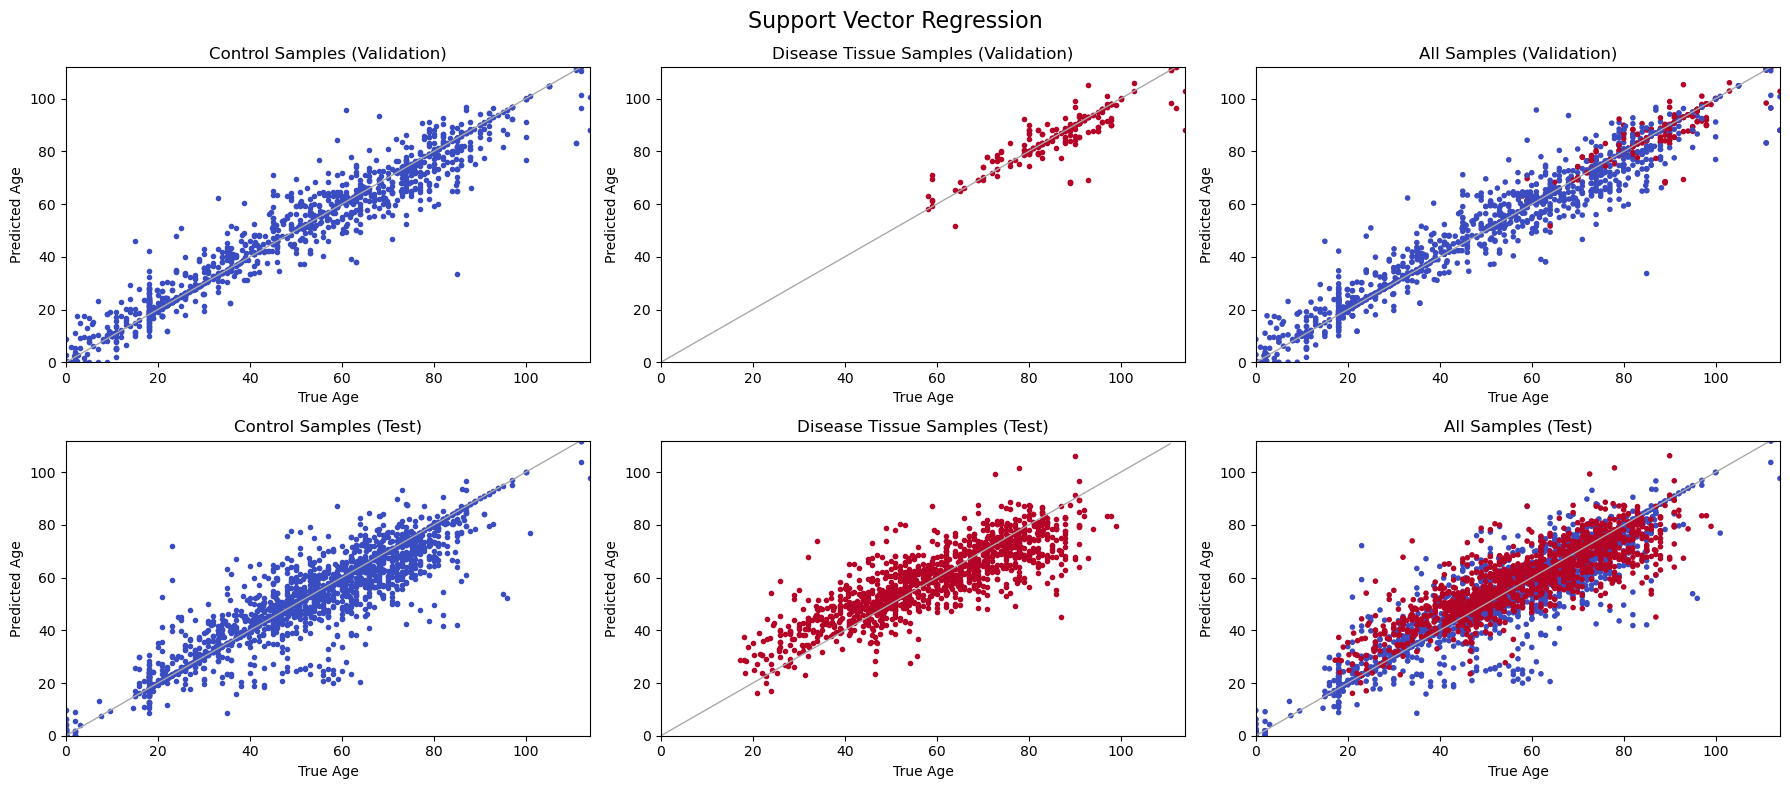

In [5]:
import matplotlib.pyplot as plt

# Separate data for control and disease tissue samples in the validation set
control_valid_mask = sample_type_valid == 0
disease_valid_mask = sample_type_valid == 1

# Separate data for control and disease tissue samples in the test set
control_test_mask = sample_test == 0
disease_test_mask = sample_test == 1

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Set title
plt.suptitle("Support Vector Regression", fontsize=16)

# Prediction line
def plot_perfect_prediction_line(ax):
    x = ax.get_xlim()
    y = ax.get_ylim()
    min_val = 0
    max_val = max(x[1], y[1])
    ax.plot([min_val, max_val], [min_val, max_val], '-', color='darkgray', linewidth=1.0)

# Plot the graphs for the validation set
axes[0, 0].scatter(age_valid[control_valid_mask], age_valid_pred[control_valid_mask], marker='.', c='#3a4dc0')
plot_perfect_prediction_line(axes[0, 0])
axes[0, 0].set_xlim(left=min(age_valid), right=max(age_valid))
axes[0, 0].set_ylim(bottom=min(age_valid_pred), top=max(age_valid_pred))
axes[0, 0].set_xlabel('True Age')
axes[0, 0].set_ylabel('Predicted Age')
axes[0, 0].set_title('Control Samples (Validation)')

axes[0, 1].scatter(age_valid[disease_valid_mask], age_valid_pred[disease_valid_mask], marker='.', c='#b40326')
plot_perfect_prediction_line(axes[0, 1])
axes[0, 1].set_xlim(left=min(age_valid), right=max(age_valid))
axes[0, 1].set_ylim(bottom=min(age_valid_pred), top=max(age_valid_pred))
axes[0, 1].set_xlabel('True Age')
axes[0, 1].set_ylabel('Predicted Age')
axes[0, 1].set_title('Disease Tissue Samples (Validation)')

axes[0, 2].scatter(age_valid, age_valid_pred, marker='.', c=sample_type_valid, cmap=plt.cm.coolwarm)
plot_perfect_prediction_line(axes[0, 2])
axes[0, 2].set_xlim(left=min(age_valid), right=max(age_valid))
axes[0, 2].set_ylim(bottom=min(age_valid_pred), top=max(age_valid_pred))
axes[0, 2].set_xlabel('True Age')
axes[0, 2].set_ylabel('Predicted Age')
axes[0, 2].set_title('All Samples (Validation)')

# Plot the graphs for the test set
axes[1, 0].scatter(age_test[control_test_mask], age_test_pred[control_test_mask], marker='.', c='#3a4dc0')
plot_perfect_prediction_line(axes[1, 0])
axes[1, 0].set_xlim(left=min(age_test), right=max(age_test))
axes[1, 0].set_ylim(bottom=min(age_test_pred), top=max(age_test_pred))
axes[1, 0].set_xlabel('True Age')
axes[1, 0].set_ylabel('Predicted Age')
axes[1, 0].set_title('Control Samples (Test)')

axes[1, 1].scatter(age_test[disease_test_mask], age_test_pred[disease_test_mask], marker='.', c='#b40326')
plot_perfect_prediction_line(axes[1, 1])
axes[1, 1].set_xlim(left=min(age_test), right=max(age_test))
axes[1, 1].set_ylim(bottom=min(age_test_pred), top=max(age_test_pred))
axes[1, 1].set_xlabel('True Age')
axes[1, 1].set_ylabel('Predicted Age')
axes[1, 1].set_title('Disease Tissue Samples (Test)')

axes[1, 2].scatter(age_test, age_test_pred, marker='.', c=sample_test, cmap=plt.cm.coolwarm)
plot_perfect_prediction_line(axes[1, 2])
axes[1, 2].set_xlim(left=min(age_test), right=max(age_test))
axes[1, 2].set_ylim(bottom=min(age_test_pred), top=max(age_test_pred))
axes[1, 2].set_xlabel('True Age')
axes[1, 2].set_ylabel('Predicted Age')
axes[1, 2].set_title('All Samples (Test)')

plt.tight_layout()
plt.show()

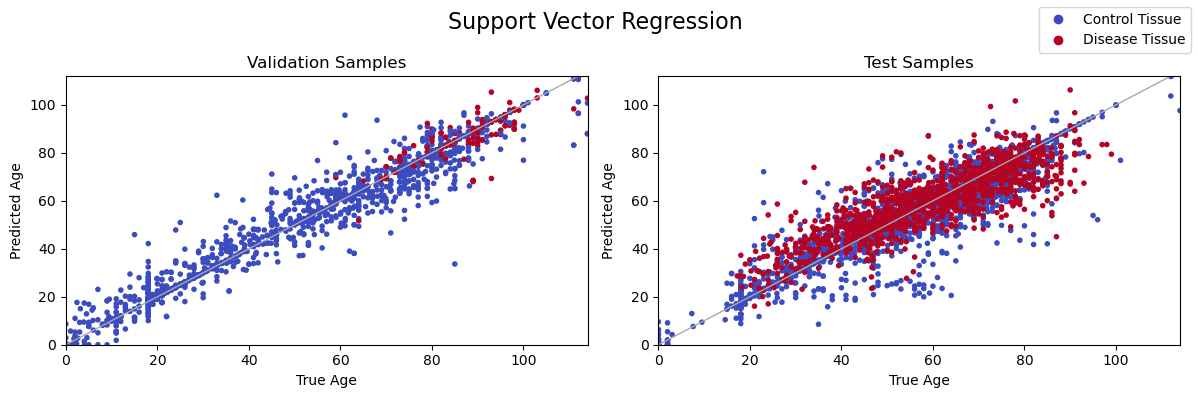

In [6]:
import matplotlib.pyplot as plt

# Separate data for control and disease tissue samples in the validation set
control_valid_mask = sample_type_valid == 0
disease_valid_mask = sample_type_valid == 1

# Separate data for control and disease tissue samples in the test set
control_test_mask = sample_test == 0
disease_test_mask = sample_test == 1

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Set title
plt.suptitle("Support Vector Regression", fontsize=16)

# Prediction line
def plot_perfect_prediction_line(ax):
    x = ax.get_xlim()
    y = ax.get_ylim()
    min_val = 0
    max_val = max(x[1], y[1])
    ax.plot([min_val, max_val], [min_val, max_val], '-', color='darkgray', linewidth=1.0)

# Plot control and disease samples with a legend
for i, ax in enumerate(axes):
    if i == 0:
        scatter = ax.scatter(age_valid, age_valid_pred, marker='.', c=sample_type_valid, cmap=plt.cm.coolwarm)
    else:
        scatter = ax.scatter(age_test, age_test_pred, marker='.', c=sample_test, cmap=plt.cm.coolwarm)

    plot_perfect_prediction_line(ax)
    ax.set_xlim(left=min(age_valid), right=max(age_valid))
    ax.set_ylim(bottom=min(age_valid_pred), top=max(age_valid_pred))
    ax.set_xlabel('True Age')
    ax.set_ylabel('Predicted Age')
    ax.set_title('Validation Samples' if i == 0 else 'Test Samples')

# Create a legend
legend_labels = ['Control Tissue', 'Disease Tissue']
legend = fig.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc="upper right")

plt.tight_layout()
plt.show()